# Algorithmic Trading Model for Naive Momentum Strategy with Volume Indicator Using Python
### David Lowe
### December 2, 2020

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template. We will test trading models with the naive momentum strategy.

INTRODUCTION: This algorithmic trading model examines a simplistic naive momentum strategy in comparison to a buy-and-hold approach. The plan goes long (buys) on the stock when the daily closing price improves from the previous day for a pre-defined consecutive number of days. Conversely, we will exit the position when the daily price declines for the same successive number of days. Furthermore, we will use the trading volumes to confirm the buy and sell signals by comparing them to the 10-day moving average.

ANALYSIS: From this iteration, we analyzed the stock prices for Apple Inc. (AAPL) between January 1, 2019, and November 27, 2020. The trading model produced a profit of 35.78 dollars per share. The buy-and-hold approach yielded a gain of 77.85 dollars per share.

CONCLUSION: For the stock of AAPL during the modeling time frame, the trading strategy did not produce a better return than the buy-and-hold approach. We should consider modeling this stock further by experimenting with more variations of the strategy.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Quandl

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Implement and Train Models
4. Back-test Models
5. Evaluate Strategy Performance

## Task 1 - Prepare Environment

In [1]:
# # Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# # Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
#
# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# # Retrieve the CPU information
# ncpu = !nproc
# print("The number of available CPUs is:", ncpu[0])

### 1.a) Load libraries and modules

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from datetime import date, datetime, timedelta
import requests
import json
from dotenv import load_dotenv
# import pandas_datareader.data as pdr

### 1.b) Set up the controlling parameters and functions¶

In [6]:
stock_symbol = 'AAPL'
initial_capital = 0

# Specify the moving average parameters for the trading strategy
CONSEC_UP_DAYS = 3
CONSEC_DN_DAYS = 3
VOL_MA_DAYS = 10

MODEL_START_DATE = date(2019, 1, 1)
print("Starting date for the model:", MODEL_START_DATE)

MODEL_END_DATE = datetime.now().date()
# model_end_date = date(2020, 11, 20)
print("Ending date for the model:", MODEL_END_DATE)

# data_start_date = model_start_date
data_start_date = MODEL_START_DATE - timedelta(days=int(VOL_MA_DAYS * 1.5)) # Need more pricing data to calculate moving averages
print("First date of data we need for modeling:", data_start_date)

data_end_date = MODEL_END_DATE
print("Last date of data we need for modeling:", data_end_date)

Starting date for the model: 2019-01-01
Ending date for the model: 2020-11-27
First date of data we need for modeling: 2018-12-17
Last date of data we need for modeling: 2020-11-27


In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Configure the plotting style
plt.style.use('seaborn')

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose_signals = False
verbose_models = True
verbose_graphs = True
verbose_portfolios = False

In [8]:
# Set up the parent directory location for loading the dotenv files

# # Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# # Set up access to the dotenv file on local PC
# env_path = "/Users/david/PycharmProjects/"
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

## Task 2 - Acquire and Pre-Process Data

In [9]:
# Set up the data service provider and data acquisition parameters
data_service = 'Quandl'

# Check and see whether the API key is available
api_key = os.environ.get('QUANDL_API')
if api_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

start_date_string = data_start_date.strftime('%Y-%m-%d')
end_date_string = data_end_date.strftime('%Y-%m-%d')
api_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, stock_symbol, api_key)
response = requests.get(api_url)
resp_dict = json.loads(response.text)
stock_rawdata = pd.DataFrame(resp_dict['datatable']['data'])
print(len(stock_rawdata), 'data points retrieved from the API call.')

492 data points retrieved from the API call.


In [10]:
stock_rawdata.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
# stock_rawdata.set_index('date', inplace=True)
stock_rawdata.index = pd.to_datetime(stock_rawdata.date)
stock_pricing = stock_rawdata.sort_index(ascending=True)
print(stock_pricing.head())
print()
print(stock_pricing.tail())

           ticker        date    open    high     low   close       volume  dividend  closeunadj lastupdated
date                                                                                                        
2018-12-17   AAPL  2018-12-17  41.362  42.087  40.682  40.985  177151688.0       0.0      163.94  2020-08-31
2018-12-18   AAPL  2018-12-18  41.345  41.883  41.097  41.517  135366072.0       0.0      166.07  2020-08-31
2018-12-19   AAPL  2018-12-19  41.500  41.862  39.773  40.222  196189188.0       0.0      160.89  2020-08-31
2018-12-20   AAPL  2018-12-20  40.100  40.528  38.825  39.208  259091840.0       0.0      156.83  2020-08-31
2018-12-21   AAPL  2018-12-21  39.215  39.540  37.407  37.682  382977536.0       0.0      150.73  2020-08-31

           ticker        date    open    high     low   close       volume  dividend  closeunadj lastupdated
date                                                                                                        
2020-11-20   AAPL 

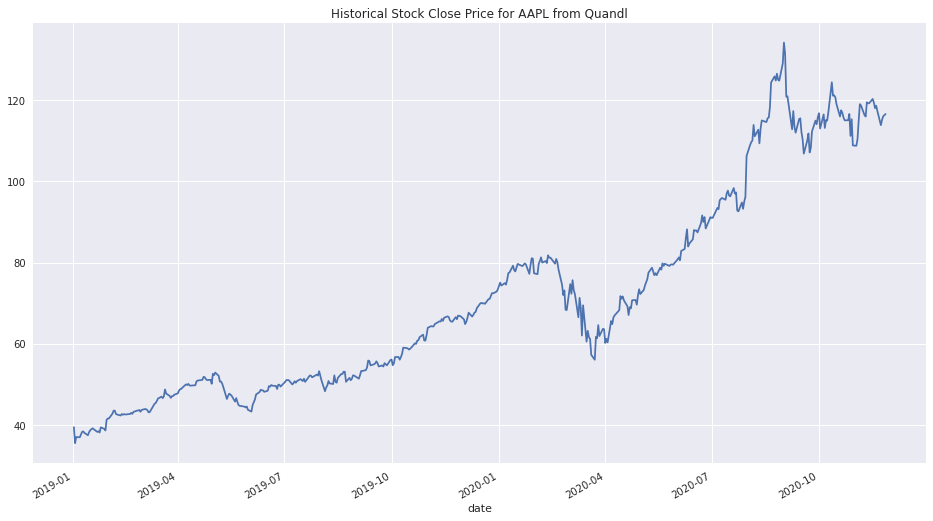

In [11]:
# Set up the standard column name for modeling
# Column names may be data-provider specific!
model_template = stock_pricing.loc[:, ['open','close','volume']]
model_template.rename(columns={'open': 'open_price', 'close': 'close_price', 'volume': 'trading_volume'}, inplace=True)
model_template = model_template[MODEL_START_DATE:MODEL_END_DATE]
plot_title = 'Historical Stock Close Price for ' + stock_symbol + ' from ' + data_service
model_template['close_price'].plot(figsize=(16,9), title=plot_title)
plt.show()

## Task 3 - Implement and Train Models

In [12]:
# Define the function that will generate the indicators and trading signals
def populate_signals(blank_model):
    trade_model = blank_model.copy()
    trade_model['volume_ma'] = trade_model['trading_volume'].rolling(VOL_MA_DAYS).mean()
    trade_model['momentum_streak'] = 0
    trade_model['trade_signal'] = 0
    trade_model['entry_exit'] = 0
    consecutive_days = 0
    prior_signal = 0
    prior_price = 0.0
    currently_own = False
    init = True
    for k in range(len(trade_model)):
        current_signal = 0
        price = trade_model.at[trade_model.index[k], 'close_price']
        trade_volume = trade_model.at[trade_model.index[k], 'trading_volume']
        average_volume = trade_model.at[trade_model.index[k], 'volume_ma']
        trade_model.at[trade_model.index[k], 'entry_exit'] = prior_signal
        if init:
            init = False
        else:
            if price > prior_price:
                if consecutive_days < 0: consecutive_days = 0
                consecutive_days += 1
            elif price < prior_price:
                if consecutive_days > 0: consecutive_days = 0
                consecutive_days -= 1
            trade_model.at[trade_model.index[k], 'momentum_streak'] = consecutive_days
            if (consecutive_days == CONSEC_UP_DAYS) and (trade_volume > average_volume) and (not currently_own):
                current_signal = 1  # trade_signal = 1 means we should buy
                currently_own = True
                consecutive_days = 0
            elif (consecutive_days == -CONSEC_DN_DAYS) and (trade_volume > average_volume) and currently_own:
                current_signal = -1  # trade_signal = -1 means we should sell
                currently_own = False
                consecutive_days = 0
        trade_model.at[trade_model.index[k], 'trade_signal'] = current_signal
        prior_signal = current_signal
        prior_price = price

    # Exiting the position on the last day of modeling period
    if currently_own:
        trade_model.at[trade_model.index[-1], 'entry_exit'] = -1

    if verbose_signals: print(trade_model)
    return trade_model

In [13]:
trading_model = populate_signals(model_template)

In [14]:
# List the entry/exit points for each model
def list_model_entry_exit(trade_model):
    print('List the signal change and entry/exit points for', stock_symbol)
    print(trade_model[(trade_model['trade_signal'] != 0) | (trade_model['entry_exit'] != 0)])

In [15]:
if verbose_models: list_model_entry_exit(trading_model)

List the signal change and entry/exit points for AAPL
            open_price  close_price  trading_volume    volume_ma  momentum_streak  trade_signal  entry_exit
date                                                                                                       
2019-03-12      45.000       45.227     129870336.0  105278131.2                3             1           0
2019-03-13      45.563       45.428     124130096.0  106556985.2                1             0           1
2019-03-26      47.916       46.697     199202152.0  147857644.0               -3            -1           0
2019-03-27      47.188       47.117     119393708.0  147384005.2                1             0          -1
2019-04-17      49.885       50.782     115627120.0   96714971.2                3             1           0
2019-04-18      50.780       50.965      96783064.0   98747567.6                1             0           1
2019-05-13      46.928       46.430     229722492.0  158138084.0               -3 

In [16]:
def draw_model_graphs(trade_model):
    graph_data = trade_model.copy()
    title_string = 'Naive Momentum Trading Model for ' + stock_symbol
    fig = plt.figure(figsize=(16,9))
    ylabel = stock_symbol + ' price in $'
    ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
    graph_data['close_price'].plot(ax=ax1, color='g')
    ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
    ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
    plt.legend(loc='upper left')
    plt.show()

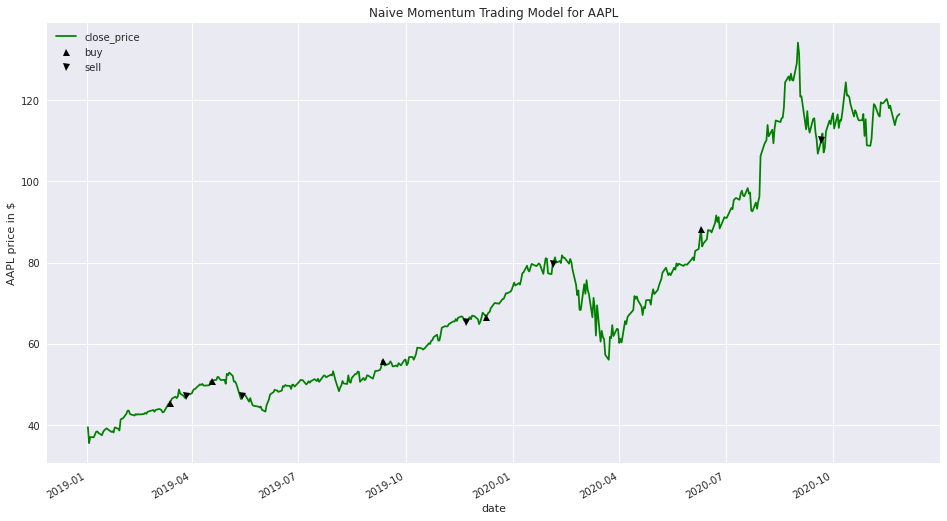

In [17]:
if verbose_graphs: draw_model_graphs(trading_model)

## Task 4 - Back-test Models

In [18]:
def generate_trading_portfolios(trade_model, initial_fund):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trade_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction', 'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accumu_return'])
    portfolio.iloc[0]['trade_action'] = 0
    portfolio.iloc[0]['qty_onhand'] = 0
    portfolio.iloc[0]['cost_basis'] = 0.00
    portfolio.iloc[0]['sold_transaction'] = 0.00
    portfolio.iloc[0]['gain_loss'] = 0.00
    portfolio.iloc[0]['cash_onhand'] = initial_capital
    portfolio.iloc[0]['position_value'] = 0.00
    portfolio.iloc[0]['total_position'] = initial_capital
    portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_position'] - initial_fund
    recent_cost = 0

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        if (trade_model.iloc[i]['entry_exit'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0):
            portfolio.iloc[i]['trade_action'] = 1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
            recent_cost = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            if verbose_portfolios: print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        elif (trade_model.iloc[i]['entry_exit'] == -1) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
            portfolio.iloc[i]['trade_action'] = -1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = 0.00
            portfolio.iloc[i]['sold_transaction'] = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
            portfolio.iloc[i]['gain_loss'] = (recent_cost + (trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
            recent_cost = 0.00
            if verbose_portfolios: print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        else:
            portfolio.iloc[i]['trade_action'] = 0
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
            portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
        portfolio.iloc[i]['position_value'] = trade_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
        portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
        portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_position'] - initial_fund

    if verbose_portfolios:
        print()
        print(portfolio)
        print()
    return portfolio

In [19]:
def calculate_portfolio_performance(trade_model):
    print('Processing portfolio for stock', stock_symbol)
    trade_portfolio = generate_trading_portfolios(trade_model, initial_capital)
    trade_transactions = trade_portfolio[trade_portfolio['trade_action'] != 0]
    print(trade_transactions)
    print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (initial_capital, trade_portfolio['accumu_return'][-1]))
    if initial_capital != 0:
        return_percentage = trade_portfolio['accumu_return'][-1] / initial_capital * 100
        print('Accumulated return percentage based on the initial capital investment: %.2f%%' % return_percentage)
    if trade_transactions.iloc[-1]['trade_action'] == 1:
        print('The current status of the model is:', 'Holding a position since', trade_transactions.index.tolist()[-1], '\n')
    else:
        print('The current status of the model is:', 'Waiting to enter since', trade_transactions.index.tolist()[-1], '\n')
    return trade_portfolio

In [20]:
trading_portfolios = calculate_portfolio_performance(trading_model)

Processing portfolio for stock AAPL
           trade_action qty_onhand cost_basis sold_transaction gain_loss cash_onhand position_value total_position accumu_return
date                                                                                                                            
2019-03-13            1          1     45.563                0         0     -45.563         45.428         -0.135        -0.135
2019-03-27           -1          0          0           47.188     1.625       1.625              0          1.625         1.625
2019-04-18            1          1      50.78                0         0     -49.155         50.965           1.81          1.81
2019-05-14           -1          0          0           46.602    -4.178      -2.553              0         -2.553        -2.553
2019-09-12            1          1       56.2                0         0     -58.753         55.771         -2.982        -2.982
2019-11-22           -1          0          0           65.64

## Task 5 - Evaluate Strategy Performance

In [21]:
# Calculate the stock's performance for a buy-and-hold model
print('The entry point for the buy-and-hold model: $%.2f on %s' % (model_template.iloc[0]['open_price'], model_template.index[0]))
print('The exit point for the buy-and-hold model: $%.2f on %s' % (model_template.iloc[-1]['open_price'], model_template.index[-1]))
print('The performance of the long-only model from day one is: $%.2f' %(model_template.iloc[-1]['open_price'] - model_template.iloc[0]['open_price']))

The entry point for the buy-and-hold model: $38.72 on 2019-01-02 00:00:00
The exit point for the buy-and-hold model: $116.57 on 2020-11-27 00:00:00
The performance of the long-only model from day one is: $77.85


In [22]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:06.399573
